In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import splitfolders
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from tqdm.autonotebook import tqdm

SEED = 7
pl.seed_everything(SEED)

Global seed set to 7


7

In [2]:
BATCH_SIZE = 7
EPOCHS = 40
NUM_WORKERS = 4
LR = 1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
IMAGE_CHANALS = 3
NUM_CLASSES = 2
BLOCK_TYPE = "bottleneck"

In [4]:
DATASET_PATH = f"./Datasets/cats_vs_dogs/"
DATASET_PATH_SPLIT = f"./Datasets/cats_vs_dogs_split"
INFERENCE_PATH = f"./Tests/cats_vs_dogs/"

In [5]:
# splitfolders.ratio(DATASET_PATH,
#                    output=DATASET_PATH_SPLIT,
#                    seed=SEED,
#                    ratio=(.8, .1, .1),
#                    group_prefix=None,
#                    move=False)

In [6]:
class CatsVSDogsDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size=1,
        num_workers=2,
        path=None,
        train_transforms=None,
        val_transforms=None,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.path = path
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms

    def setup(self, stage=None):
        self.train_set = tv.datasets.ImageFolder(
            f"{self.path}/train/", transform=self.train_transforms)
        self.val_set = tv.datasets.ImageFolder(f"{self.path}/val/",
                                               transform=self.val_transforms)
        self.test_set = tv.datasets.ImageFolder(f"{self.path}/test/",
                                                transform=self.val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_set,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers,
                          drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_set,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers,
                          drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.test_set,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers,
                          drop_last=True)


In [7]:
class ResBlock(torch.nn.Module):
    def __init__(self, num_ch):
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.2)

        self.conv0 = torch.nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1)
        self.norm0 = torch.nn.BatchNorm2d(num_ch)

        self.conv1 = torch.nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(num_ch)

    def forward(self, x: torch.Tensor):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        return out + x

In [8]:
class ResBottleneckBlock(torch.nn.Module):
    def __init__(self, num_ch):
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.2)

        self.conv0 = torch.nn.Conv2d(num_ch,
                                     num_ch // 4,
                                     kernel_size=1,
                                     padding=0)
        self.norm0 = torch.nn.BatchNorm2d(num_ch // 4)

        self.conv1 = torch.nn.Conv2d(num_ch // 4,
                                     num_ch // 4,
                                     kernel_size=3,
                                     padding=1)
        self.norm1 = torch.nn.BatchNorm2d(num_ch // 4)

        self.conv2 = torch.nn.Conv2d(num_ch // 4,
                                     num_ch,
                                     kernel_size=1,
                                     padding=0)
        self.norm2 = torch.nn.BatchNorm2d(num_ch)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)

        return x + out

In [9]:
class ResStackBlock(torch.nn.Module):
    def __init__(self, num_blocks: int, num_ch: int, block_type="classic"):
        super().__init__()
        stack = []

        for i in range(num_blocks):
            if block_type == "classic":
                stack.append(ResBlock(num_ch))
            elif block_type == "bottleneck":
                stack.append(ResBottleneckBlock(num_ch))
            else:
                raise NotImplementedError(f'{block_type} is not implemented')

        self.stack = torch.nn.Sequential(*stack)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

In [10]:
class ResNETClassifier(pl.LightningModule):
    def __init__(self,
                 lr=1e-3,
                 input_ch=3,
                 num_classes=2,
                 num_ch=32,
                 block_type="classic"):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.unput_ch = input_ch
        self.num_classes = num_classes
        self.num_ch = num_ch
        self.block_type = block_type

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.conv0 = torch.nn.Conv2d(input_ch, num_ch, kernel_size=7, stride=2)
        self.act = torch.nn.LeakyReLU(0.2)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer1 = ResStackBlock(num_blocks=3,
                                    num_ch=num_ch,
                                    block_type=block_type)
        self.conv1x1_1 = torch.nn.Conv2d(num_ch, 2*num_ch, kernel_size=1, stride=2)
        self.conv1_1 = torch.nn.Conv2d(in_channels=num_ch,
                                       out_channels=2 * num_ch,
                                       kernel_size=3,
                                       padding=1,
                                       stride=2)
        self.conv1_2 = torch.nn.Conv2d(in_channels=2 * num_ch,
                                       out_channels=2 * num_ch,
                                       kernel_size=3,
                                       padding=1)

        self.layer2 = ResStackBlock(num_blocks=3,
                                    num_ch=2 * num_ch,
                                    block_type=block_type)
        self.conv1x1_2 = torch.nn.Conv2d(2*num_ch, 4*num_ch, kernel_size=1, stride=2)
        self.conv2_1 = torch.nn.Conv2d(in_channels=2 * num_ch,
                                       out_channels=4 * num_ch,
                                       kernel_size=3,
                                       padding=1,
                                       stride=2)
        self.conv2_2 = torch.nn.Conv2d(in_channels=4 * num_ch,
                                       out_channels=4 * num_ch,
                                       kernel_size=3,
                                       padding=1)
        self.layer3 = ResStackBlock(num_blocks=5,
                                    num_ch=4 * num_ch,
                                    block_type=block_type)
        self.conv1x1_3 = torch.nn.Conv2d(4*num_ch, 8*num_ch, kernel_size=1, stride=2)
        self.conv3_1 = torch.nn.Conv2d(in_channels=4 * num_ch,
                                       out_channels=8 * num_ch,
                                       kernel_size=3,
                                       padding=1,
                                       stride=2)
        self.conv3_2 = torch.nn.Conv2d(in_channels=8 * num_ch,
                                       out_channels=8 * num_ch,
                                       kernel_size=3,
                                       padding=1)
        self.layer4 = ResStackBlock(num_blocks=2,
                                    num_ch=8 * num_ch,
                                    block_type=block_type)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(8 * num_ch, num_classes)

        self.loss = torch.nn.CrossEntropyLoss()
        self.metrics = {
            "accuracy":
            Accuracy(task="multiclass",
                     num_classes=self.num_classes).to(device)
        }
        self.preds_stage = {
            "train": {
                "loss": [],
                "accuracy": []
            },
            "valid": {
                "loss": [],
                "accuracy": []
            },
            "test": {
                "loss": [],
                "accuracy": []
            }
        }

    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.max_pool(out)

        out = self.layer1(out)
        tmp = self.conv1x1_1(out)
        out = self.conv1_1(out)
        out = self.conv1_2(out)

        out = self.layer2(out+tmp)
        tmp = self.conv1x1_2(out)
        out = self.conv2_1(out)
        out = self.conv2_2(out)

        out = self.layer3(out+tmp)
        tmp = self.conv1x1_3(out)
        out = self.conv3_1(out)
        out = self.conv3_2(out)

        out = self.layer4(out+tmp)
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out

    def shared_step(self, sample, stage):
        x, y = sample
        preds = self.forward(x)
        loss = self.loss(preds, y)
        self.preds_stage[stage]['loss'].append(loss.detach().cpu())
        self.preds_stage[stage]['accuracy'].append(self.metrics["accuracy"](
            preds.argmax(dim=1), y).detach().cpu())
        return loss

    def shared_epoch_end(self, stage):
        loss = self.preds_stage[stage]['loss']
        loss = torch.stack(loss)
        loss = np.mean([x.item() for x in loss])

        acc = self.preds_stage[stage]['accuracy']
        acc = torch.stack(acc)
        acc = np.mean([x.item() for x in acc])

        metrics = {f"{stage}_loss": loss, f"{stage}_acc": acc}

        self.log_dict(metrics, prog_bar=True)

        self.preds_stage[stage]['loss'].clear()
        self.preds_stage[stage]['accuracy'].clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler_dict = {
            "scheduler":
            torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5),
            "interval":
            "epoch",
            "monitor":
            "valid_loss"
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_training_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")


In [11]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize((120, 120)),
    tv.transforms.ToTensor(),
    tv.transforms.ConvertImageDtype(torch.float32)
])

In [12]:
dm = CatsVSDogsDataModule(BATCH_SIZE, NUM_WORKERS, DATASET_PATH_SPLIT, transforms, transforms)
dm.setup()

In [13]:
model = ResNETClassifier(LR, IMAGE_CHANALS, NUM_CLASSES, block_type=BLOCK_TYPE)

callbacks = [
    ModelCheckpoint(dirpath='Models',
                    filename='{epoch}_{valid_acc:.2f}_{valid_loss:.2f}',
                    save_top_k=1,
                    monitor='valid_acc',
                    mode='max'),
    LearningRateMonitor(logging_interval="step"),
    EarlyStopping(monitor="valid_acc",
                  min_delta=2e-4,
                  patience=5,
                  verbose=False,
                  mode="max")
]

TENSOR = "./Logs/"
logger = TensorBoardLogger(TENSOR, name="MyResNETCatsVSDogs")

trainer = pl.Trainer(accelerator= "gpu", max_epochs=EPOCHS, logger=logger, callbacks=callbacks)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
CHECKPOINT = None
trainer.fit(model, dm, ckpt_path=CHECKPOINT)

c:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:604: UserWarning: Checkpoint directory D:\random\JupiterProjects\DeepModelTraining\DeepImageClassification\ResNET\models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type              | Params
-------------------------------------------------
0  | conv0     | Conv2d            | 4.7 K 
1  | act       | LeakyReLU         | 0     
2  | max_pool  | MaxPool2d         | 0     
3  | layer1    | ResStackBlock     | 3.7 K 
4  | conv1x1_1 | Conv2d            | 2.1 K 
5  | conv1_1   | Conv2d            | 18.5 K
6  | conv1_2   | Conv2d            | 36.9 K
7  | layer2    | ResStackBlock     | 13.9 K
8  | conv1x1_2 | Conv2d            | 8.3 K 
9  | conv2_1   | Conv2d            | 73.9 K
10 | conv2_2   | Conv2d            | 147 K 
11 | layer3    | ResStackBlock     | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [15]:
trainer.test(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8451380640351805     │
│         test_loss         │    0.5485541116214699     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5485541116214699, 'test_acc': 0.8451380640351805}]

In [16]:
def inference_model(inference_data, model):
    inference_images = []
    inference_predictions = []
    model.eval()
    with torch.no_grad():
        for img, label in inference_data:
            inference_images.append(img.permute(1, 2, 0))
            outs = model(img[None,:]).detach().cpu()
            inference_predictions.append(inference_data.classes[torch.argmax(torch.softmax(outs, 1), 1)])
    model.train()
    return inference_images, inference_predictions

In [17]:
def show_results(n_rows, n_cols, n_samples, inference_images, inference_predictions):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 6))
    k = 0

    for j in range(n_rows):
        for i in range(n_cols):
            if k<n_samples:
                axes[j, i].imshow(inference_images[k])
                axes[j, i].set_title(f"Prediction: {inference_predictions[k]}")
                k+=1
            else:
                 fig.delaxes(axes[j, i])
            axes[j, i].get_xaxis().set_visible(False)
            axes[j, i].get_yaxis().set_visible(False)

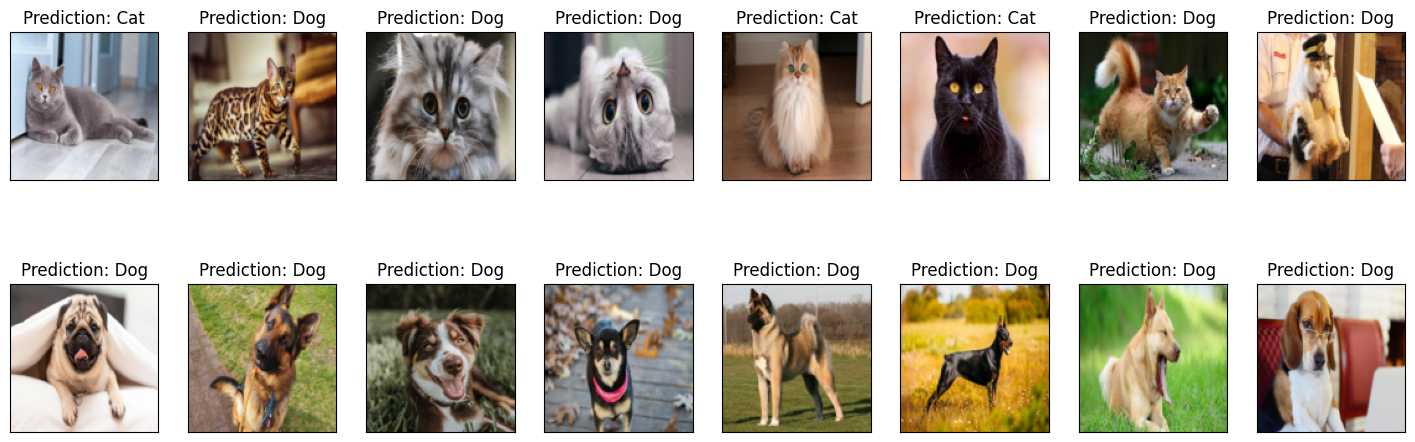

In [18]:
inference_data = tv.datasets.ImageFolder(INFERENCE_PATH, transform=transforms)

inference_images, inference_predictions = inference_model(inference_data, model)
show_results(2, 8, 16, inference_images, inference_predictions)

In [1]:
%load_ext tensorboard
%tensorboard --logdir ./logs/

Reusing TensorBoard on port 6006 (pid 10396), started 0:01:13 ago. (Use '!kill 10396' to kill it.)